# Causal Discovery and Markov Blanket

In [ ]:
!pip install causal-learn
!pip install rpy2
!pip install datasets
!pip install pyCausalFS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.9/300.9 kB 8.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

# Causal discovery
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from datasets import load_dataset

import rpy2

from sklearn.metrics import f1_score, precision_score, recall_score
# Set random seed for reproducibility
np.random.seed(42)
sns.set_style('whitegrid')

In [ ]:
# Visualization helpers
def plot_graph(ax, graph, *, target, blanket_nodes=None, default_color="lightblue", title, pos=None):
    """Plot a directed graph highlighting target and Markov blanket nodes."""
    if blanket_nodes is None:
        blanket_nodes = set()
    else:
        blanket_nodes = set(blanket_nodes)

    if pos is None:
        pos = nx.circular_layout(graph)

    node_colors = []
    for node in graph.nodes:
        if node == target:
            node_colors.append("red")
        elif node in blanket_nodes:
            node_colors.append("orange")
        else:
            node_colors.append(default_color)

    nx.draw(
        graph,
        pos,
        ax=ax,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        font_size=10,
        font_weight="bold",
        arrows=True,
        arrowsize=20,
        edge_color="gray",
    )
    ax.set_title(title, fontsize=12, fontweight="bold")
    return pos


def plot_adjacency_matrix(ax, adj_matrix, *, title):
    """Plot an adjacency matrix with consistent styling."""
    im = ax.imshow(adj_matrix, cmap="binary", aspect="auto")
    n_nodes = adj_matrix.shape[0]
    ax.set_xticks(range(n_nodes))
    ax.set_yticks(range(n_nodes))
    ax.set_xlabel("To Node", fontweight="bold")
    ax.set_ylabel("From Node", fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    return im

## 1. Load Dataset and Read Example

In [ ]:
# Load dataset
datasets = load_dataset("CSE472-blanket-challenge/phase1-dataset", split="train")

README.md: 0.00B [00:00, ?B/s]

phase1_dataset.jsonl:   0%|          | 0.00/9.86M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90 [00:00<?, ? examples/s]

In [ ]:
example_idx = 5
example = datasets[example_idx]

print(f"\nSelected example {example_idx}:")
print(f"  Graph ID: {example['graph_id']}")
print(f"  Number of nodes: {example['num_nodes']}")
print(f"  Number of edges: {example['num_edges']}")
print(f"  Density: {example['density']:.4f}")
print(f"  Target variable: {example['target_variable']}")
print(f"  Oracle Markov blanket: {[i for i, x in enumerate(example['markov_blanket']) if x == 1]}")
print(f"  Data shape: {np.array(example['data']).shape}")
print(f"  Method: {example['method']}")


Selected example 5:
  Graph ID: graph_482684d6
  Number of nodes: 10
  Number of edges: 9
  Density: 0.1000
  Target variable: 7
  Oracle Markov blanket: [0, 3, 5, 6, 8, 9]
  Data shape: (500, 10)
  Method: PA


In [ ]:
# Reconstruct the DAG from adjacency matrix
adj_matrix = np.array(example["adjacency_matrix"])
n_nodes = example["num_nodes"]
target = example["target_variable"]
mb = example["markov_blanket"]
oracle_mb = np.where(np.array(mb) == 1)[0].tolist()

# Create NetworkX graph
true_dag = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

## 2. Visualize True DAG and Adjacency Matrix

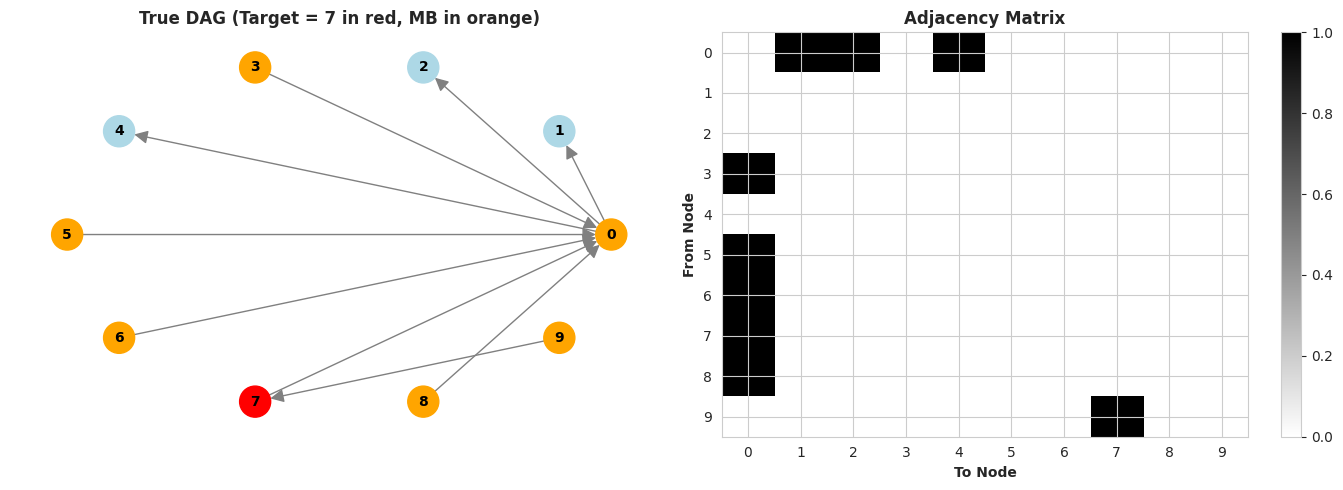

In [ ]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

true_pos = plot_graph(
    axes[0],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title=f"True DAG (Target = {target} in red, MB in orange)",
)

im = plot_adjacency_matrix(
    axes[1],
    adj_matrix,
    title="Adjacency Matrix",
)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Run PC Algorithm for Causal Discovery

We use [causal-learn](https://github.com/py-why/causal-learn)'s PC algorithm in this demo.

You are free to try other packages as well.

In [ ]:
# Prepare data for PC algorithm
data_array = np.array(example["data"])  # Shape: (n_samples, n_nodes)
print(f"Data shape for PC: {data_array.shape}")

# Run PC algorithm
# check https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html for parameters choice
cg = pc(data_array, alpha=0.05, indep_test=fisherz, stable=True, verbose=False)

discovered_graph = cg.G.graph
# causal-learn represents graph in -1,0,1 format
# convert to 0,1 adjacency matrix
pc_adj = (discovered_graph == 1).astype(int)

Data shape for PC: (500, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

PC returns a class of graph called CPDAG, CPDAG contains undirected edges when the direction cannot be determined from conditional independence tests alone.

There are several ways to resolve the undirected edges
1. one simple way is to randomly assign directions to undirected edges while ensuring no cycles are formed.
2. the other way is to assign both directions, but the graph will no longer be a DAG. For casual feature selection, sometimes it's okay to have redundant edges.

In [ ]:
# is discovered graph a DAG?
discovered_g = nx.from_numpy_array(pc_adj, create_using=nx.DiGraph)
nx.is_directed_acyclic_graph(discovered_g)

True

## 4. Extract Markov Blanket from PC Results

CD-based MB methods recipe

1. Run causal discovery algorithm
2. Resolve the discovered graph if it's not a DAG
3. Extract MB of the target variable from the graph

In [ ]:
# Compute Markov blanket from discovered graph

def find_markov_blanket(adj_matrix, target):
    """Compute Markov blanket: parents + children + co-parents (spouses)."""
    graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

    parents = set(graph.predecessors(target))
    children = set(graph.successors(target))

    co_parents = set()
    for child in children:
        co_parents.update(graph.predecessors(child))
    co_parents.discard(target)

    markov_blanket = parents | children | co_parents
    return sorted(markov_blanket)


# Get Markov blankets
pc_mb = find_markov_blanket(pc_adj, target)

print("=== Markov Blanket Comparison ===")
print(f"Target variable: {target}")
print(f"Oracle MB: {oracle_mb}")
print(f"PC-derived MB: {pc_mb}")
print(f"Oracle MB size: {len(oracle_mb)}")
print(f"PC MB size: {len(pc_mb)}")

=== Markov Blanket Comparison ===
Target variable: 7
Oracle MB: [0, 3, 5, 6, 8, 9]
PC-derived MB: [0, 2]
Oracle MB size: 6
PC MB size: 2


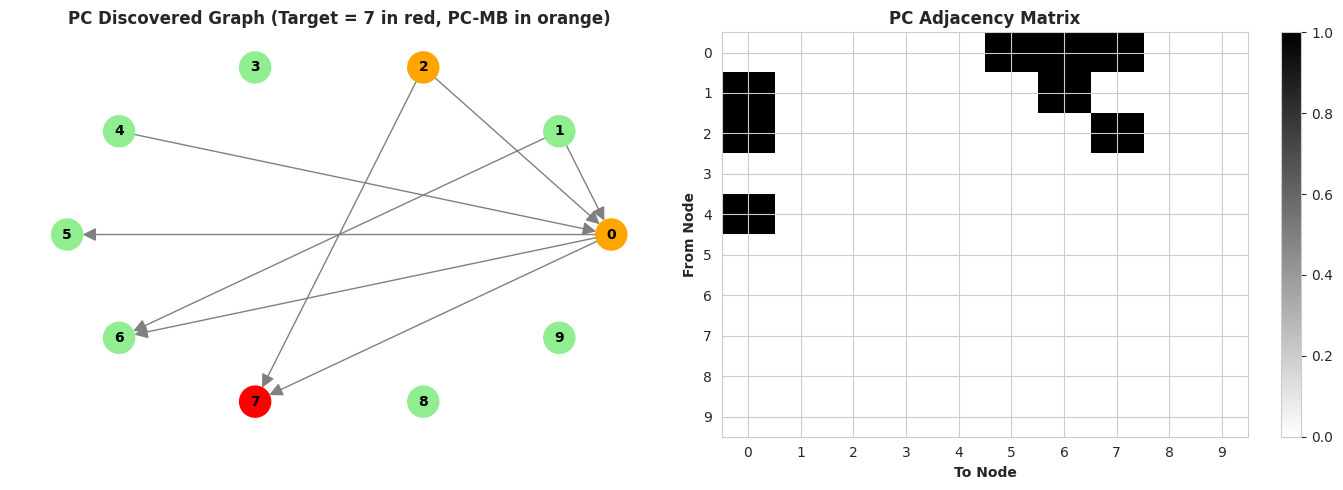

In [ ]:
# Visualize discovered graph
pc_dag = nx.from_numpy_array(pc_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    pc_dag,
    target=target,
    blanket_nodes=pc_mb,
    default_color="lightgreen",
    title=f"PC Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

im = plot_adjacency_matrix(
    axes[1],
    pc_adj,
    title="PC Adjacency Matrix",
)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

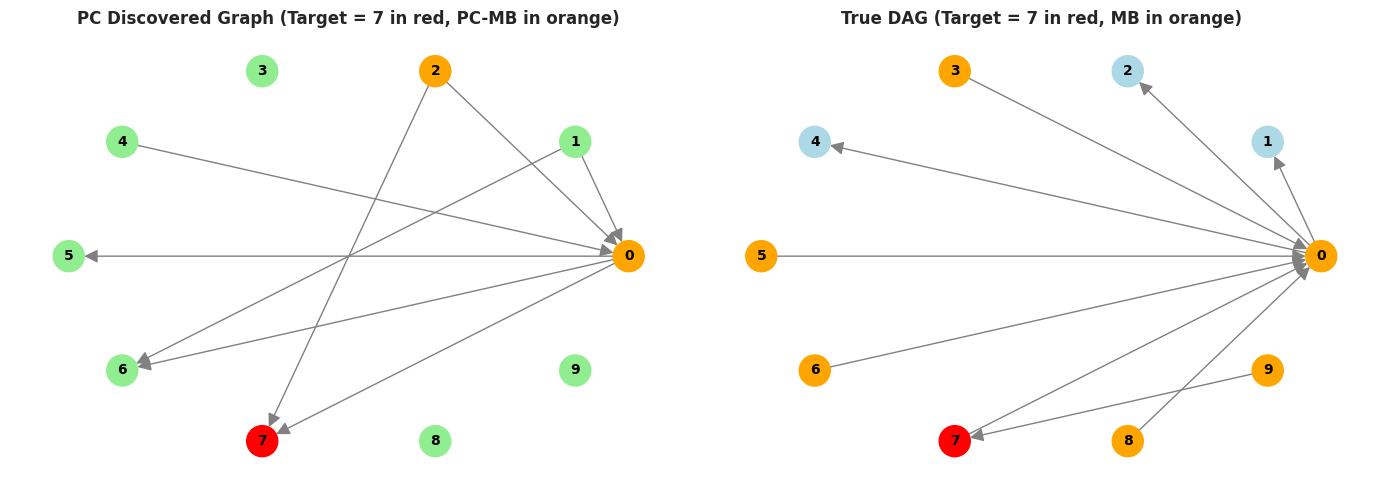

In [ ]:
# compare discoverd graph with true graph
# Visualize discovered graph
pc_dag = nx.from_numpy_array(pc_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    pc_dag,
    target=target,
    blanket_nodes=pc_mb,
    default_color="lightgreen",
    title=f"PC Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

plot_graph(
    axes[1],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title=f"True DAG (Target = {target} in red, MB in orange)",
)

plt.tight_layout()
plt.show()

## 5. Evaluate PC Performance with Metrics

In [ ]:
def calculate_shd(true_adj, pred_adj):
    """Calculate SHD: number of edge additions, deletions, and reversals."""
    n = true_adj.shape[0]
    shd = 0

    for i in range(n):
        for j in range(n):
            if i == j:
                continue

            true_edge = true_adj[i, j]
            pred_edge = pred_adj[i, j]

            # Edge addition or deletion
            if true_edge != pred_edge:
                shd += 1

    return shd // 2  # Divide by 2 since we count each edge twice

# Calculate edge-level precision, recall, F1
def calculate_edge_metrics(true_adj, pred_adj):
    """Calculate precision, recall, F1 for edge prediction using scikit-learn metrics."""
    true_flat = true_adj.reshape(-1)
    pred_flat = pred_adj.reshape(-1)

    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)
    f1 = f1_score(true_flat, pred_flat, zero_division=0)

    return precision, recall, f1


# Calculate metrics
shd = calculate_shd(adj_matrix, pc_adj)
precision, recall, f1 = calculate_edge_metrics(adj_matrix, pc_adj)

print("=== PC Algorithm Performance ===")
print(f"Structural Hamming Distance (SHD): {shd}")
print(f"Edge Precision: {precision:.3f}")
print(f"Edge Recall: {recall:.3f}")
print(f"Edge F1 Score: {f1:.3f}")
print(f"\nTrue edges: {true_dag.number_of_edges()}")
print(f"Discovered edges: {pc_dag.number_of_edges()}")


=== PC Algorithm Performance ===
Structural Hamming Distance (SHD): 8
Edge Precision: 0.000
Edge Recall: 0.000
Edge F1 Score: 0.000

True edges: 9
Discovered edges: 8


## Your turn

1. Implement at least one other causal discovery method (e.g., GES, FCI)
   1. use one of the packages provided
2. Implement specialized causal feature selection methods (IAMB)
   1. R package bnlearn provide IAMB and fast IAMB implementation. Using [rpy2](https://rpy2.github.io/) or write a R script to run it (if you're familiar with R)

In [ ]:
data_array = np.array(example["data"])


In [ ]:
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
G, _ = bic_exact_search(data_array)

In [ ]:
test_adj = G.astype(int)
test_mb = find_markov_blanket(test_adj, target)

print("=== Markov Blanket Comparison ===")
print(f"Target variable: {target}")
print(f"Oracle MB: {oracle_mb}")
print(f"PC-derived MB: {test_mb}")
print(f"Oracle MB size: {len(oracle_mb)}")
print(f"PC MB size: {len(test_mb)}")

=== Markov Blanket Comparison ===
Target variable: 7
Oracle MB: [0, 3, 5, 6, 8, 9]
PC-derived MB: [0, 3, 5, 6, 8, 9]
Oracle MB size: 6
PC MB size: 6


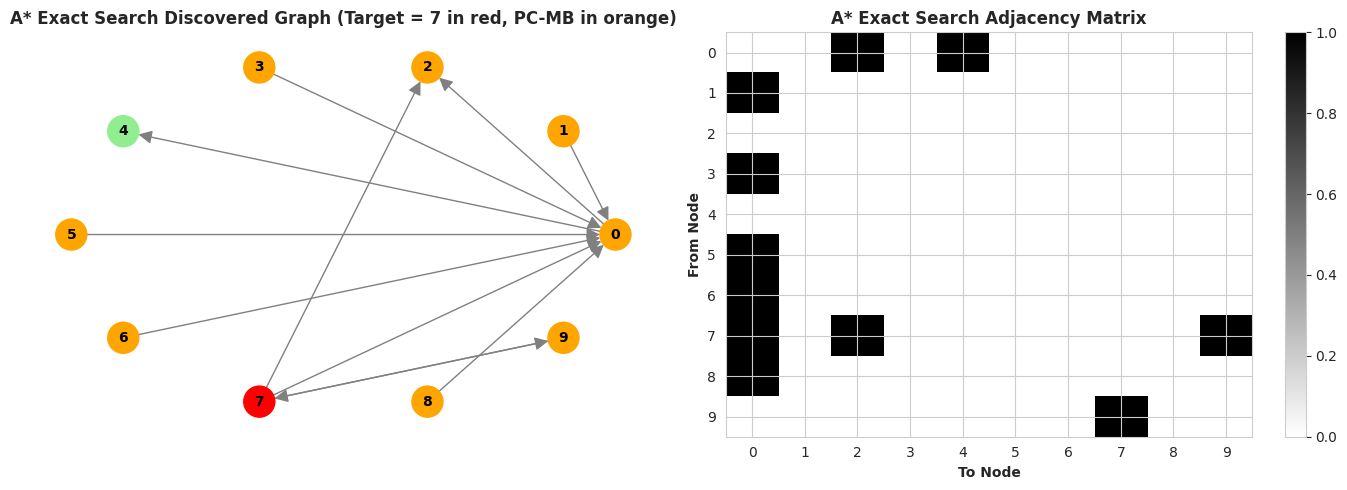

In [ ]:
# Visualize discovered graph
test_dag = nx.from_numpy_array(test_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    test_dag,
    target=target,
    blanket_nodes=test_mb,
    default_color="lightgreen",
    title=f"A* Exact Search Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

im = plot_adjacency_matrix(
    axes[1],
    test_adj,
    title="A* Exact Search Adjacency Matrix",
)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

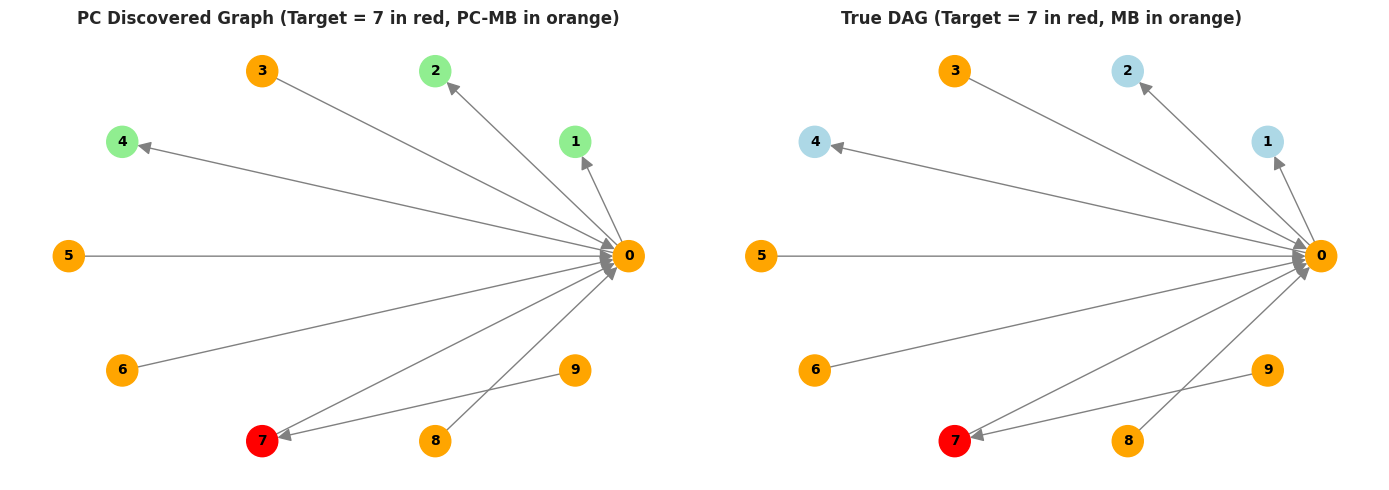

In [ ]:
# compare discoverd graph with true graph
# Visualize discovered graph
test_dag = nx.from_numpy_array(test_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    test_dag,
    target=target,
    blanket_nodes=test_mb,
    default_color="lightgreen",
    title=f"PC Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

plot_graph(
    axes[1],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title=f"True DAG (Target = {target} in red, MB in orange)",
)

plt.tight_layout()
plt.show()

In [ ]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Import R's utility functions
utils = rpackages.importr('utils')

# Choose a CRAN mirror
utils.chooseCRANmirror(ind=1) # The index 1 corresponds to a specific mirror

# Install bnlearn
utils.install_packages(StrVector(['bnlearn']))

(as ‘lib’ is unspecified)







	‘/tmp/RtmpRpRC4D/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7821e870ae10> [0]

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [ ]:
# Activate the pandas to R conversion
pandas2ri.activate()

# Import the bnlearn package
bnlearn = rpackages.importr('bnlearn')

In [ ]:
import pandas as pd
df = pd.DataFrame(data_array)

In [ ]:
r_df = ro.conversion.py2rpy(df)

# Run the IAMB algorithm
# The iamb function in R takes the data frame as its first argument
# and you can specify the target node using the 'target' parameter.
result = bnlearn.iamb(r_df)

# Print the learned structure
print(result)


  Bayesian network learned via Constraint-based methods

  model:
    [partially directed graph]
  nodes:                                 10 
  arcs:                                  10 
    undirected arcs:                     1 
    directed arcs:                       9 
  average markov blanket size:           5.00 
  average neighbourhood size:            2.00 
  average branching factor:              0.90 

  learning algorithm:                    IAMB 
  conditional independence test:         Pearson's Correlation 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  639 




In [ ]:
adjacency_matrix_r = bnlearn.amat(result)

In [ ]:
test_adj = np.array(adjacency_matrix_r)
test_mb = find_markov_blanket(test_adj, target)

print("=== Markov Blanket Comparison ===")
print(f"Target variable: {target}")
print(f"Oracle MB: {oracle_mb}")
print(f"PC-derived MB: {test_mb}")
print(f"Oracle MB size: {len(oracle_mb)}")
print(f"PC MB size: {len(test_mb)}")

=== Markov Blanket Comparison ===
Target variable: 7
Oracle MB: [0, 3, 5, 6, 8, 9]
PC-derived MB: [0, 1, 2, 3, 5, 6, 8, 9]
Oracle MB size: 6
PC MB size: 8


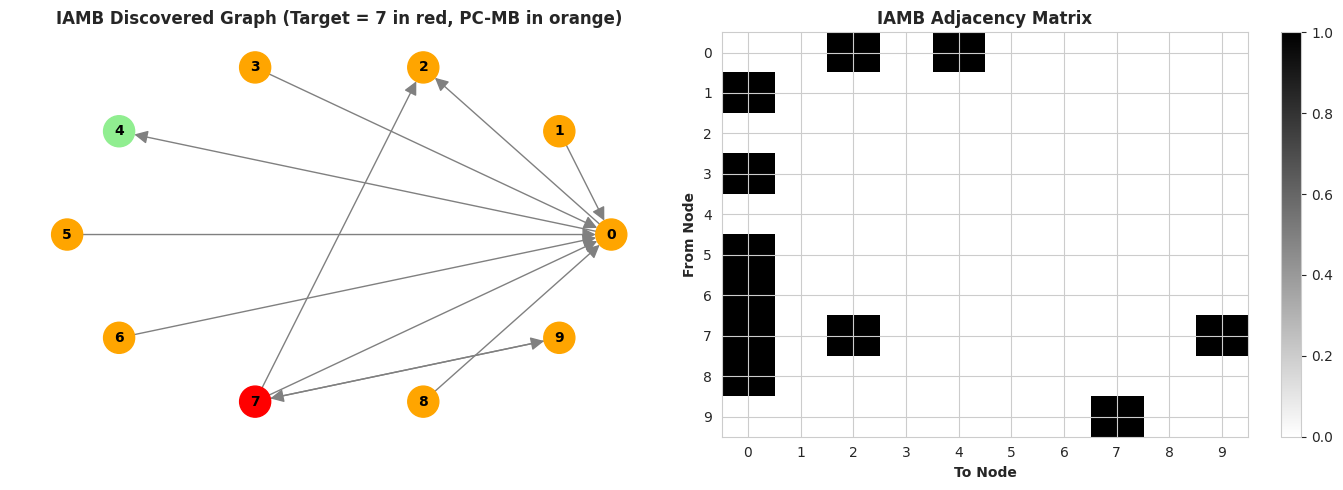

In [ ]:
# Visualize discovered graph
test_dag = nx.from_numpy_array(test_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    test_dag,
    target=target,
    blanket_nodes=test_mb,
    default_color="lightgreen",
    title=f"IAMB Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

im = plot_adjacency_matrix(
    axes[1],
    test_adj,
    title="IAMB Adjacency Matrix",
)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

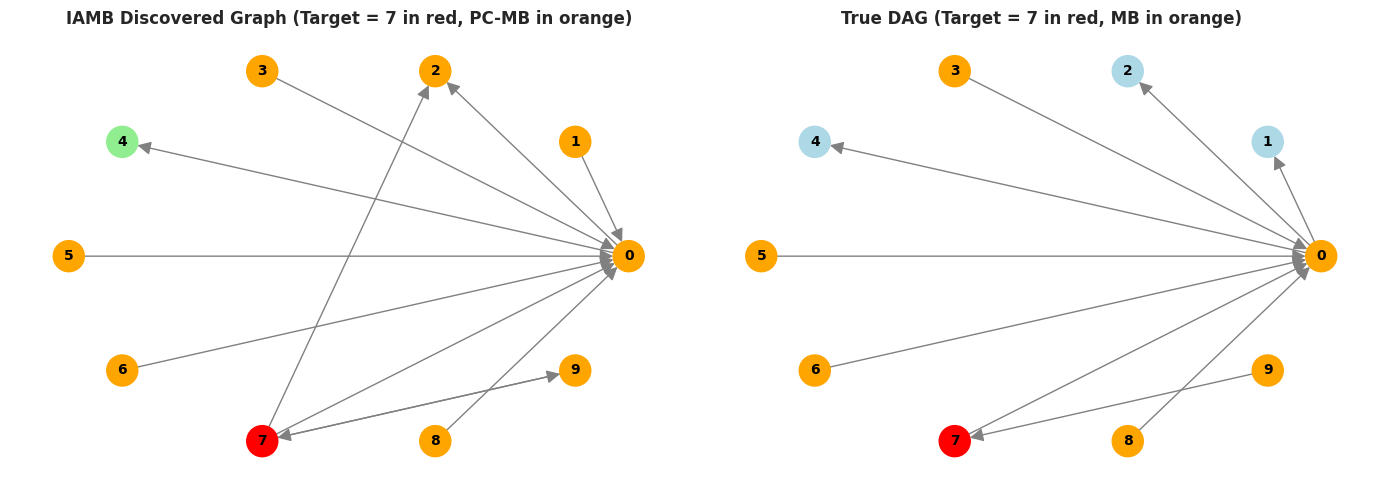

In [ ]:
# compare discoverd graph with true graph
# Visualize discovered graph
test_dag = nx.from_numpy_array(test_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    test_dag,
    target=target,
    blanket_nodes=test_mb,
    default_color="lightgreen",
    title=f"IAMB Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

plot_graph(
    axes[1],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title=f"True DAG (Target = {target} in red, MB in orange)",
)

plt.tight_layout()
plt.show()

## Questions

1. Can PC or CD in general recover the DAG well?
   1. If not, what do you observe? Can you improve it by adjusting hyperparameters?
   2. If not, what's your hypothesis?
2. What's the relationship of size of Markov Blanket (w.r.t total nodes) and density of the graph?
3. Is dedicated causal feature selection method (IAMB) working better than causal discovery methods?

PC does not recover the DAG well. The exact search CD method works well.

It seems that markov blankets have edge counts that are proportional to the number of nodes.

The IAMB method works better than the PC algorithm but worse than exact search.